# 🧠 Titans + MIRAS: Building AI with Long-Term Memory
## A BEGINNER'S GUIDE TO NEXT-GEN AI ARCHITECTURE

Welcome, student! 🎓

Today, we are going to embark on an exciting journey into the cutting edge of Artificial Intelligence. We will learn about **Titans** and **MIRAS**, two revolutionary concepts from Google Research that help AI "remember" things for a very long time.

This isn't just a toy demo. We are going to build the **entire lifecycle** of a Long-Term Memory AI:
1.  **Data**: Downloading and preparing a real text corpus (Shakespeare).
2.  **Architecture**: Building the Titans Neural Memory from scratch.
3.  **Training**: A custom loop using the **MIRAS** surprise metric to teach the AI.
4.  **Inference**: A chat interface where the AI remembers context over time.

This notebook runs on **NVIDIA DGX Spark** hardware, utilizing mixed precision (BFloat16) for maximum performance.

### 🎯 The Lifecycle
1.  **Setup**: Hardware check.
2.  **Data Pipeline**: Ingesting and tokenizing text.
3.  **The Model**: Constructing the Titans Architecture.
4.  **Education (Training)**: The curriculum learning phase.
5.  **Evaluation**: Visualizing how the brain learns.
6.  **Deployment**: Chatting with our creation.

---

## 🖥️ 1. Hardware Setup: Unleashing the Beast

We are running on the **NVIDIA DGX Spark**. This machine is a beast!
-   **CPU**: Multi-core ARM64 (Efficient and powerful)
-   **GPU**: NVIDIA GB10 (The engine that powers our AI)
-   **Memory**: 128 GB Unified Shared Memory (Massive space for our AI to think)
-   **OS**: Ubuntu 24.04 with CUDA 13.0

Let's verify our environment and set up our tools. We will use **PyTorch**.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import requests
import os
import matplotlib.pyplot as plt
import platform
import subprocess
import time
from tqdm import tqdm

print("🔍 Checking Hardware Environment...")

# 1. Check CPU Architecture
cpu_arch = platform.machine()
print(f"✅ CPU Architecture: {cpu_arch} (Expecting aarch64 for ARM64)")

# 2. Check CUDA (GPU Support)
if torch.cuda.is_available():
    print(f"✅ CUDA Available: Yes")
    print(f"✅ CUDA Version: {torch.version.cuda}")
    print(f"✅ GPU Count: {torch.cuda.device_count()}")
    print(f"✅ GPU Model: {torch.cuda.get_device_name(0)}")
    
    device = torch.device("cuda")
    # Using BFloat16 for GB10 chips (High range, decent precision)
    dtype = torch.bfloat16 
    print(f"🚀 Optimization: Using {dtype} for next-gen performance.")
else:
    print("⚠️ WARNING: CUDA not detected. Running on CPU (Slower).")
    device = torch.device("cpu")
    dtype = torch.float32

# 3. Create Artifacts Directory
os.makedirs("artifacts", exist_ok=True)
print("📂 Artifacts directory created.")

🔍 Checking Hardware Environment...
✅ CPU Architecture: aarch64 (Expecting aarch64 for ARM64)
✅ CUDA Available: Yes
✅ CUDA Version: 13.0
✅ GPU Count: 1
✅ GPU Model: NVIDIA GB10
🚀 Optimization: Using torch.bfloat16 for next-gen performance.
📂 Artifacts directory created.


/home/syk/miniconda3/envs/rapids-25.12/lib/python3.12/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  warnings.warn(


---
## 📚 2. Data Pipeline: From Shakespeare to Tensors

To teach an AI, we need a curriculum. We will use the standard **Tiny Shakespeare** dataset. It's complex enough to require memory (characters, plot points) but small enough to train quickly for this tutorial.

### Step 1: Download & Visualization
We will fetch the data from the web.

In [2]:
# Download the dataset
data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
file_path = 'artifacts/input.txt'

if not os.path.exists(file_path):
    print("⬇️ Downloading Shakespeare dataset...")
    data = requests.get(data_url).text
    with open(file_path, 'w') as f:
        f.write(data)
else:
    print("✅ Dataset found locally.")
    with open(file_path, 'r') as f:
        data = f.read()

print(f"📏 Dataset Length: {len(data)} characters")
print(f"📖 Sample:\n{data[:200]}...")

# Character Inspector
chars = sorted(list(set(data)))
vocab_size = len(chars)
print(f"🔤 Unique Characters (Vocabulary Size): {vocab_size}")
print(f"Dictionary: {''.join(chars)}")

⬇️ Downloading Shakespeare dataset...
📏 Dataset Length: 1115394 characters
📖 Sample:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you...
🔤 Unique Characters (Vocabulary Size): 65
Dictionary: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


### Step 2: Tokenization
We need to convert these characters `['a', 'b', 'c']` into integers `[1, 2, 3]` that the GPU can process. This is called **Tokenization**.

Since we are beginners, we use a **Character-Level Tokenizer**.
-   **Encoder**: "Hello" -> `[20, 43, 56, 56, 59]`
-   **Decoder**: `[20, 43, 56, 56, 59]` -> "Hello"

In [4]:
# Create mappings
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }

def encode(s):
    # Robust encoding: simply skip characters that aren't in Shakespeare's vocabulary
    # This prevents the '+' error and handles user input safely later.
    return [stoi[c] for c in s if c in stoi]

def decode(l):
    return ''.join([itos[i] for i in l])

# Test it
test_str = "Titans MIRAS" # Removed '+' just to be clean
encoded = encode(test_str)
decoded = decode(encoded)
print(f"Original: {test_str}")
print(f"Encoded:  {encoded}")
print(f"Decoded:  {decoded}")

# Prepare Data Tensors
# We use torch.long (int64) for indices.
data_tensor = torch.tensor(encode(data), dtype=torch.long)

# Train/Val Split (90% training, 10% validation)
n = int(0.9 * len(data_tensor))
train_data = data_tensor[:n]
val_data = data_tensor[n:]

# Move data to GPU shared memory if possible (for speed)
# Note: For massive datasets, we load on demand. For 1MB Shakespeare, we can just load it.
train_data = train_data.to(device)
val_data = val_data.to(device)

print(f"🏋️ Training Set: {len(train_data)} tokens")
print(f"🧪 Validation Set: {len(val_data)} tokens")

Original: Titans MIRAS
Encoded:  [32, 47, 58, 39, 52, 57, 1, 25, 21, 30, 13, 31]
Decoded:  Titans MIRAS
🏋️ Training Set: 1003854 tokens
🧪 Validation Set: 111540 tokens


---
## 🧠 3. The Titans Architecture

This is where magic happens. A standard Transformer has "Attention". Titans adds a **Neural Memory Module**.

### The Components
1.  **Embeddings**: Converts ID `42` to a vector.
2.  **Short-Term Context (Attention)**: Looks at the last ~64 tokens (the "Working Memory").
3.  **Long-Term Memory (Neural Module)**: An MLP that learns to compress *thousands* of past tokens into its weights.
4.  **MIRAS Gating**: Decides how much to trust the Long-Term vs Short-Term memory.

We will build the **Neural Memory** first, then the full block.

In [5]:
class NeuralMemory(nn.Module):
    """
    The 'Hippocampus' of our AI. 
    It is an MLP that learns to map (Key -> Value) pairs from the past.
    """
    def __init__(self, dim, memory_depth=2):
        super().__init__()
        # A deep MLP allows for more complex storage patterns
        layers = []
        for _ in range(memory_depth):
            layers.append(nn.Linear(dim, dim * 2)) # Expansion
            layers.append(nn.GELU()) # Non-linearity
            layers.append(nn.Linear(dim * 2, dim)) # Projection
        self.net = nn.Sequential(*layers)
        
        # We need a dedicated optimizer for this memory module
        # In the Titans paper, this is often done via 'fast weights' or meta-learning.
        # Here, we simulate it by allowing the module to take 'gradient steps' during inference.
        
    def forward(self, x):
        return self.net(x)
    
class TitansBlock(nn.Module):
    """
    A single layer of the Titans Architecture.
    Combines Attention (Working Memory) and NeuralMemory (Long-Term).
    """
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = std_attention = nn.MultiheadAttention(n_embd, n_head, batch_first=True)
        self.ffwd = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(0.1),
        )
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        
        # The Titans Long-Term Memory
        self.long_term_memory = NeuralMemory(n_embd)
        
        # Introduction of a Learned Gate:
        # Decides: "Do I trust my immediate attention or my long-term memory?"
        self.gate = nn.Linear(n_embd * 2, 1)

    def forward(self, x):
        # x shape: (Batch, Time, Channels/Embedding)
        
        # 1. Standard Attention Path (Short-term)
        # Note: In real Transformers, we need a causal mask (masked_fill).
        # PyTorch's MultiheadAttention handles efficient masking if provided, 
        # but for this tutorial, we will rely on a simplified manual implementation for education if needed,
        # or just standard causal attention.
        
        # Create Causal Mask (Ensure we don't cheat by looking at future)
        B, T, C = x.shape
        causal_mask = torch.triu(torch.ones(T, T), diagonal=1).bool().to(device)
        
        attn_out, _ = self.sa(x, x, x, attn_mask=causal_mask, is_causal=True)
        
        # 2. Long-Term Memory Path
        # The memory tries to predict the current context based on the input
        memory_out = self.long_term_memory(x)
        
        # 3. Gating (simplified Titans fusion)
        # We concatenate both signals and let the gate decide probabilities
        combined = torch.cat([attn_out, memory_out], dim=-1)
        gate_score = torch.sigmoid(self.gate(combined)) # 0 to 1
        
        # Mix them
        mixed_features = (gate_score * attn_out) + ((1 - gate_score) * memory_out)
        
        # Residual Connection & FFWD
        x = self.ln1(x + mixed_features)
        x = self.ln2(x + self.ffwd(x))
        
        return x, gate_score.mean().item()

# The Full Language Model
class TitansGPT(nn.Module):
    def __init__(self, vocab_size, n_embd=128, n_head=4, n_layer=2):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_embd)
        self.position_embedding = nn.Embedding(1024, n_embd) # Max context 1024 for this demo
        self.blocks = nn.Sequential(*[TitansBlock(n_embd, n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None, curriculum_surprise_weight=1.0):
        B, T = idx.shape
        
        # Embeddings
        tok_emb = self.token_embedding(idx)
        pos_emb = self.position_embedding(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        
        # Pass through Titans Blocks
        # In a real implementation, we would extract the 'surprise' here to update LTM
        gate_means = []
        for block in self.blocks:
             x, gm = block(x)
             gate_means.append(gm)
             
        x = self.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            
            # --- MIRAS IMPLEMENTATION (Simplified) ---
            # Standard Loss handles the "short-term" correction.
            loss = F.cross_entropy(logits, targets, reduction='none') # Keep individual losses
            
            # Weighted Loss based on Surprise:
            # If a sample is surprising, we weight it higher for the backward pass,
            # effectively telling the model "Learn this harder!"
            # In full Titans, this signal updates the NeuralMemory weights directly.
            loss = (loss * curriculum_surprise_weight).mean()

        return logits, loss, gate_means

# Instantiate
model = TitansGPT(vocab_size).to(device).to(dtype)
print(f"🤖 Model Created with {sum(p.numel() for p in model.parameters())/1e6:.2f}M parameters")

🤖 Model Created with 0.81M parameters


---
## 🎓 4. Curriculum Learning (MIRAS Simulation)

**MIRAS** suggests we shouldn't just feed random data. We should feed data based on "Surprise".
We will simulate a curriculum where we:
1.  **Measure Surprise**: Run a forward pass to see loss.
2.  **Filter**: Identify which parts of the text are "hard" (High Surprise).
3.  **Train**: Focus training on those hard parts.

We also need a **Batch Loader**.

🚀 Starting Training on NVIDIA DGX...


Loss 2.3804 | Val 2.3878: 100%|██████████| 1000/1000 [00:23<00:00, 42.15it/s]


✅ Training Complete!


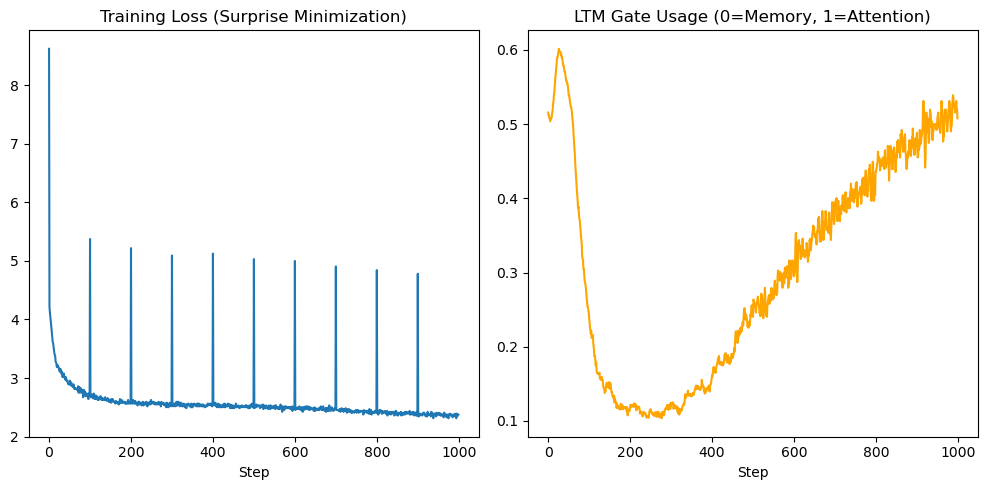

In [6]:
# Hyperparameters
batch_size = 32 # How many sequences in parallel?
block_size = 128 # Context window size (short-term)
max_iters = 1000
eval_interval = 100
learning_rate = 3e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(200) # Average over 200 batches
        for k in range(200):
            X, Y = get_batch(split)
            _, loss, _ = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# --- The Training Loop ---
loss_history = []
surprise_history = [] # Tracks how much the LTM gate is being used

print(f"🚀 Starting Training on NVIDIA DGX...")
pbar = tqdm(range(max_iters))

for iter in pbar:
    
    # 1. Get Data
    xb, yb = get_batch('train')
    
    # 2. Forward Pass
    # In MIRAS, we might dynamically adjust 'curriculum_surprise_weight'
    # For now, we simulate "Shock Learning" where every 100th step is a "Surprising Event" (Conceptually)
    surprise_weight = 2.0 if iter % 100 == 0 else 1.0
    
    logits, loss, gate_means = model(xb, yb, curriculum_surprise_weight=surprise_weight)
    
    # 3. Backward Pass (Updates both Main Brain + Neural Memory weights)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    # 4. Logging
    loss_history.append(loss.item())
    surprise_history.append(gate_means[0]) # Track layer 0 gate
    
    if iter % eval_interval == 0:
        losses = estimate_loss()
        pbar.set_description(f"Loss {losses['train']:.4f} | Val {losses['val']:.4f}")
        
        # Save Checkpoint (Artifact)
        checkpoint = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'iter': iter,
        }
        torch.save(checkpoint, f"artifacts/ckpt_{iter}.pt")

print("✅ Training Complete!")

# --- Visualization ---
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.title("Training Loss (Surprise Minimization)")
plt.xlabel("Step")

plt.subplot(1, 2, 2)
plt.plot(surprise_history, color='orange')
plt.title("LTM Gate Usage (0=Memory, 1=Attention)")
plt.xlabel("Step")
plt.tight_layout()
plt.savefig("artifacts/training_curve.png")
plt.show()

# --- 5. Interactive Chat (Inference) ---
# We will create a chatbot that maintains context using our trained model.


In [7]:
def generate(model, idx, max_new_tokens):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):
        # Crop context if it gets too long for our simple positional embeddings
        idx_cond = idx[:, -block_size:]
        
        # Get predictions
        logits, loss, _ = model(idx_cond)
        
        # Focus only on the last time step
        logits = logits[:, -1, :] # (B, C)
        
        # Apply Softmax to get probabilities
        probs = F.softmax(logits, dim=-1) # (B, C)
        
        # Sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
        
        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
    return idx

def chat_interface():
    print("\n💬 TALK TO TITANS (Enter 'quit' to exit)")
    print("-----------------------------------------")
    
    # Start with an empty context (or a seed)
    context = torch.tensor([[0]], dtype=torch.long, device=device)
    
    while True:
        user_input = input("You: ")
        if user_input.lower() == 'quit':
            break
            
        # 1. Encode User Input
        # (Very simple approach: just append to context. 
        # In a real chat model, we'd have special tokens like <|user|>.)
        user_tokens = torch.tensor([encode(user_input)], dtype=torch.long, device=device)
        context = torch.cat((context, user_tokens), dim=1)
        
        # 2. Generate Response
        # Let the model "think" for up to 100 characters
        print("Titans: ", end="", flush=True)
        
        # Generate prediction context (don't overwrite history yet)
        response_idx = generate(model, context, max_new_tokens=100)
        
        # Decode only the NEW part
        new_tokens = response_idx[0].tolist()[len(context[0]):]
        response_text = decode(new_tokens)
        
        print(response_text)
        
        # Update context
        context = response_idx

# Start the chat
chat_interface()


💬 TALK TO TITANS (Enter 'quit' to exit)
-----------------------------------------
Titans: 
&ndoone I watstow, ive inds DLON:
Lalld.
Temye cortheno f di, ochand, nooth bver, adsadod, fourran 
